# Preprocessing (imputation, standardization, final clean) and modeling
sklearn modeling the median imputed training data using min/max clinically guided aggregation. 
preprocessing includes variable formatting (categorical to factor variables in r, train/test split, and median imputation).


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from pathlib import Path
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, pairwise, f1_score, log_loss, make_scorer
from sklearn.metrics import precision_score, recall_score
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.joblib import Memory
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, Imputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import validation
from scipy.sparse import issparse
from scipy.spatial import distance
from sklearn import svm

#importin xg boost and all needed otherstuff
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier #conda install -c conda-forge xgboost to install
##adding these, lets see if it helps with xgboost crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#reducing warnings that are super common in my model
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore') #ignore all warnings

#memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

RANDOM_STATE = 15485867

%matplotlib inline
plt.style.use('seaborn-white')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

## importing datasets and doing final formatting/processing

In [2]:
#patients of interest from rotation_cohort_generation
from parameters import final_pt_df_v, date, repository_path, lower_window, upper_window, folder, date, time_col, time_var, patient_df, categorical, save_boolean
#patients of interest from rotation_cohort_generation
final_pt_df2 = final_pt_df_v #pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/%s_final_pt_df2.csv'%(most_updated_patient_df), index_col=0)
del(final_pt_df_v)

patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 1.01 s


In [3]:
len(patients)

15412

time: 3.82 ms


In [4]:
len(icustay_id)

19633

time: 1.42 ms


In [5]:
folder

'24_hr_window'

time: 1.81 ms


In [6]:
# ###########
# save_boolean=False
# ############

time: 320 µs


In [7]:
address=str(repository_path)+'/data/cleaned_merged_agg/'+'%s/'%(folder)
train_data= pd.read_csv(Path(address+'%s_%s_cleaned_merged_agg.csv' %(date, 'train')), index_col=0)
test_data= pd.read_csv(Path(address+'%s_%s_cleaned_merged_agg.csv' %(date, 'test')), index_col=0)

time: 109 ms


In [8]:
### added 11/8/19: removed daily sofa score from prediction model, since the components used to calculate it are already in model
### 12/12/19:  #removing o2_flow since it is mostly sparce and is not a helpful variable
train_data.drop('daily_sofa', axis=1, inplace=True)
test_data.drop('daily_sofa', axis=1, inplace=True)
train_data.drop('o2_flow', axis=1, inplace=True)
test_data.drop('o2_flow', axis=1, inplace=True)
categorical.remove('o2_flow')

time: 12.1 ms


In [9]:
train_data['pao2fio2ratio'].head()

0    0.145556
1    0.087095
2    0.017347
3    0.145556
4    0.145556
Name: pao2fio2ratio, dtype: float64

time: 4.59 ms


## getting descriptive numbers for publication

In [10]:
final_pt_df2.head()#['icustay_id'].nunique()

,icustay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end,...,subject_id,dod_hosp,dod_ssn,ab_course,org_list,spec_type_list,first_pos_else_neg_ssc,sc_result,final_bin,hadm_id
0,294638,2191-03-16 00:00:00,22,2191-03-16 00:29:31,1213116,2191-03-16,2191-03-22,0 days 00:00:00.000000000,2191-03-16,2191-03-22,...,4,NaN,NaN,full,STAPH AUREUS COAG +,BLOOD CULTURE,2191-03-16 00:00:00,positive,C_pos/A_full,185777
1,220597,2149-11-10 09:40:00,45,2149-11-09 13:07:02,2089126,2149-11-10,2149-11-15,0 days 00:00:00.000000000,2149-11-10,2149-11-15,...,9,2149-11-14,2149-11-14,full,NaN,NaN,2149-11-10 09:40:00,negative,C_neg/A_full,150750
2,232669,2104-08-11 00:00:00,60,2104-08-08 02:08:17,616189,2104-08-11,2104-08-12,0 days 00:00:00.000000000,2104-08-11,2104-08-12,...,12,2104-08-20,2104-08-20,partial,NaN,NaN,2104-08-11 00:00:00,negative,C_neg/A_partial,112213
3,273430,2108-08-05 20:42:00,69,2108-08-05 16:26:09,2572274,2108-08-06,2108-08-08,1 days 00:00:00.000000000,2108-08-06,2108-08-08,...,19,NaN,2109-08-18,partial,NaN,NaN,2108-08-05 20:42:00,negative,C_neg/A_partial,109235
4,217847,2134-09-11 09:35:00,70,2134-09-11 20:50:04,1388217,2134-09-12,2134-09-13,1 days 00:00:00.000000000,2134-09-12,2134-09-13,...,21,2135-02-08,2135-02-08,full,NaN,NaN,2134-09-11 09:35:00,negative,C_neg/A_full,109451


time: 25.7 ms


In [11]:
final_pt_df2.loc[final_pt_df2['final_bin'].isin(['C_neg/A_partial','C_pos/A_full']),'subject_id'].nunique()

8938

time: 6.03 ms


In [12]:
list(train_data)

['icustay_id',
 'bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'potassium',
 'ptt',
 'resprate',
 'sum_elix',
 'temperature',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'pao2fio2ratio',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 "('max', 'calcium')",
 "('max', 'sodium')",
 "('max', 'wbc')",
 "('min', 'calcium')",
 "('min', 'sodium')",
 "('min', 'wbc')",
 'any_vasoactives',
 'bands',
 'cancer_elix',
 'dobutamine',
 'dopamine',
 'epinephrine',
 'ethnicity',
 'gender',
 'leukocyte',
 'nitrite',
 'norepinephrine',
 'pco2',
 'phenylephrine',
 'rrt',
 'vasopressin',
 'vent_recieved',
 'weight',
 'yearsold']

time: 3.48 ms


In [13]:
full_demo=pd.concat([train_data[['icustay_id','yearsold','ethnicity','gender']],test_data[['icustay_id','yearsold','ethnicity','gender']]])

time: 7.57 ms


In [14]:
full_demo.describe()

,icustay_id,yearsold
count,10305.000000,10305.000000
mean,249857.183212,64.683707
std,28968.046750,17.083992
min,200012.000000,16.022154
25%,224498.000000,53.250160
50%,249804.000000,66.362190
75%,275055.000000,78.443464
max,299995.000000,90.000000


time: 40.6 ms


In [15]:
full_demo.head()

,icustay_id,yearsold,ethnicity,gender
0,200012.0,32.988959,asian,F
1,200014.0,84.728186,unknown/other,M
2,200033.0,67.145099,white/nonhispanic,M
3,200036.0,74.934136,white/nonhispanic,M
4,200055.0,31.593200,black,F


time: 6.97 ms


In [16]:
full_demo.merge(final_pt_df2[['icustay_id','subject_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    7867
C_pos/A_full       2438
Name: final_bin, dtype: int64

time: 25.5 ms


In [17]:
full_demo['yearsold'].min()

16.0221538076406

time: 3.88 ms


In [18]:
full_demo['ethnicity'].value_counts()

white/nonhispanic    7472
black                1130
unknown/other         995
hispanic              433
asian                 275
Name: ethnicity, dtype: int64

time: 4.99 ms


In [19]:
full_demo['ethnicity'].value_counts()

white/nonhispanic    7472
black                1130
unknown/other         995
hispanic              433
asian                 275
Name: ethnicity, dtype: int64

time: 5.62 ms


In [20]:
full_demo['gender'].value_counts()

M    5706
F    4599
Name: gender, dtype: int64

time: 5.87 ms


In [21]:
test_data[['icustay_id','yearsold','ethnicity','gender']].head()

,icustay_id,yearsold,ethnicity,gender
0,200030.0,54.191893,black,M
1,200063.0,37.073163,unknown/other,M
2,200078.0,65.225284,white/nonhispanic,M
3,200109.0,71.609613,unknown/other,M
4,200116.0,56.506077,white/nonhispanic,M


time: 9.04 ms


In [22]:
train_data.merge(final_pt_df2[['icustay_id','subject_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    5512
C_pos/A_full       1693
Name: final_bin, dtype: int64

time: 22.8 ms


In [10]:
test_data.merge(final_pt_df2[['icustay_id','subject_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    2355
C_pos/A_full        745
Name: final_bin, dtype: int64

time: 31.8 ms


In [25]:
final_pt_df2['final_bin'].value_counts()

C_neg/A_partial    7867
C_neg/A_full       7401
C_pos/A_full       2438
C_pos/A_partial    1927
Name: final_bin, dtype: int64

time: 5.14 ms


## back to the formatting and final preprocessing

In [23]:
def rename_fxn(data):
    """
    renames data columns to be more readable.
    """
    rename_dic={
    "('max', 'sodium')": "maxSodium" ,
    "('max', 'sodium')" : "maxSodium",
    "('min', 'sodium')" : "minSodium",
    "('max', 'calcium')" : "maxCalcium",
    "('min', 'calcium')" : "minCalcium",
    "('max', 'sodium')": "maxSodium",
    "('min', 'sodium')": "minSodium",
    "('max', 'wbc')": "maxWBC",
    "('min', 'wbc')": "minWBC"#,
#     "bands": "ibands",
#     "pco2": "ipco2"
        }
    data=data.rename(rename_dic, axis='columns').copy()
    return(data)

time: 7.12 ms


In [24]:
def last_minute_clean(data):
    "some last minute data cleaning steps that were missed prior to this. eventually should be transitioned to earlier in pipeline"
    data.loc[data['ethnicity'].isnull(), 'ethnicity']='unknown/other'
    data.loc[data['yearsold']>90,"yearsold"]=90
    return(data)

time: 3.52 ms


In [25]:
def standardize_fxn(data):
    """
    function operations:
    2) standardize last 2 columns to be standardized (weight and age)
    """
    from sklearn.impute import SimpleImputer
    
    ### I chose to standardize the weight and age here (after the feature_aggregation)... I can't remember why though. either way, it doesn't affect anything, but is a bit clunky. 
    weight_median=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).median()
    weight_quant1=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.25)#.between(train_data['col'].quantile(.25), df['col'].quantile(.75), inclusive=True)]
    weight_quant3=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.75)
    weight_iqr=weight_quant3-weight_quant1
    #print(weight_median,weight_quant3,weight_quant1, weight_iqr)

    age_median=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).median()
    age_quant1=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).quantile(0.25)
    age_quant3=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).quantile(0.75)
    age_iqr=age_quant3-age_quant1

    #converting to log scaled standardized data for age/weight
    data['weight']=data['weight'].apply(lambda x: (np.log(x+1)-weight_median)/weight_iqr)
    data['yearsold']=data['yearsold'].apply(lambda x: (np.log(x+1)-age_median)/age_iqr)
    
    return(data)

time: 29 ms


In [26]:
def remap_categorical(data, categorical):
    """remapps the 0 and 1 back to interpretable values in the dataframe. useful to use before onehot encoding. also useful to fill in some missing values and nan's"""   

    remapping_dic={
    'vent_recieved':{0:'None', 2:'Mech' , 1:'OxygenTherapy', np.nan:'None'},
    'cancer_elix':{0:'no_cancer_cormorb', 1:'cancer_comorbidity'},
    'gender':{0:'F', 1:'M', np.nan:'NA'},
    'leukocyte':{0:'Neg/Not_tested' , 1:'pos'},
    'nitrite':{0:'Neg/Not_tested' , 1:'pos'},
    'rrt':{0:'not_recieved' , 1:'recieved'},
    'phenylephrine':{0:'not_recieved' , 1:'recieved'},
    'norepinephrine':{0:'not_recieved' , 1:'recieved'},
    'vasopressin':{0:'not_recieved' , 1:'recieved'},
    'dobutamine':{0:'not_recieved' , 1:'recieved'},
    'dopamine':{0:'not_recieved' , 1:'recieved'},
    'epinephrine':{0:'not_recieved' , 1:'recieved'},
    'any_vasoactives':{0:'not_recieved' , 1:'recieved'},
    'o2_flow':{0:'no_flow', 1:"recieved_O2"}
    }
    
    for col in list(data):
        if col in ['ethnicity', 'bands','pco2']:
            pass
        elif col in categorical:
            data[col]=data[col].replace(remapping_dic[col])
        
    return(data)

time: 70.2 ms


In [27]:
def onehotencoder(data, categorical):
    """
    function operations:
    3) convert categorical columns to proper format
    """

    data = pd.get_dummies(data, columns = categorical, drop_first=True)
    return(data)

time: 3.61 ms


In [28]:
def median_imputer(data, categorical):
    """
    function operations:
    4) median impute
    """
    from sklearn.impute import SimpleImputer
    
    #pop outcome off
    outcome= data.pop("final_bin").values
       
    #impute
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    imp.fit(data[[x for x in list(data) if x not in categorical]]) 
    data[[x for x in list(data) if x not in categorical]]= imp.transform(data[[x for x in list(data) if x not in categorical]])
    
    #reattach outcome
    data['final_bin']= outcome
    return(data)

time: 17.7 ms


In [29]:
def preprocessing(data, encode=True):
    """
    function operations: (each one of the below steps uses one of the functions defined above.)
    1) rename columns
    2) some last minute cleanup
    3) standardize last 2 columns to be standardized
    4) median impute 
    5) remap categorical values to be interpretable and encode them for modeling
    6)
    """
    from sklearn.impute import SimpleImputer
    
    ###rename
    data=rename_fxn(data)
    
    ###some last minute data cleaning steps that were missed prior to this. eventually should be transitioned to earlier in pipeline
    data=last_minute_clean(data)
    
    ##scale & standardize the remaining 2 columns (age and weight)
    data=standardize_fxn(data)
    
    ### onehot encoding categorical var
    
    #remapping the 0 and 1 back to categorical values for more interpreable onehotencoding column headings
    data=remap_categorical(data, categorical)
    
    #impute
    data= median_imputer(data, categorical)
    
    #onehotencoding
    if encode==True:
        data=onehotencoder(data, categorical)
    
    #binarizing and poping outcome for training data
    data.loc[data['final_bin']=="C_pos/A_full","final_bin"]=1
    data.loc[data['final_bin']=="C_neg/A_partial","final_bin"]=0
    data['final_bin']=pd.to_numeric(data['final_bin'])
    
    ## establishing training data and labels
    x= data.copy()
    z_icustay_id=x.pop('icustay_id')
    y= x.pop("final_bin").values
    
    return(x, y, z_icustay_id)

time: 38.1 ms


# todo: get some statistics on missingness right before i perform imputation.

In [30]:
x_train, y_train, z_icustay_id = preprocessing(pd.merge(train_data, final_pt_df2[['icustay_id','final_bin']]))
x_test, y_test, z_icustay_id_test= preprocessing(pd.merge(test_data, final_pt_df2[['icustay_id','final_bin']]))

z_subject_id=pd.merge(pd.DataFrame(z_icustay_id), final_pt_df2[['icustay_id','subject_id']], how='left')['subject_id'] #7205

time: 506 ms


In [117]:
y.reshape(1,-1).ravel()

array([0, 0, 1, ..., 0, 0, 0])

time: 2.53 ms


In [31]:
x_train2, y_train2, z_icustay_id2 = preprocessing(pd.merge(train_data, final_pt_df2[['icustay_id','final_bin']]),encode=False)
x_test2, y_test2, z_icustay_id_test2= preprocessing(pd.merge(test_data, final_pt_df2[['icustay_id','final_bin']]),encode=False)


time: 369 ms


In [32]:
###checking distribution of all categorical variables
full_set=pd.concat([x_train2,x_test2])
for element in categorical:
    print("###{}###".format(element))
    print(full_set[element].value_counts(), '\n')

###ethnicity###
white/nonhispanic    7472
black                1130
unknown/other         995
hispanic              433
asian                 275
Name: ethnicity, dtype: int64 

###bands###
absent    8952
<10        856
>10        497
Name: bands, dtype: int64 

###pco2###
absent    6798
<50       2499
>50       1008
Name: pco2, dtype: int64 

###any_vasoactives###
not_recieved    7362
recieved        2943
Name: any_vasoactives, dtype: int64 

###leukocyte###
Neg/Not_tested    8959
pos               1346
Name: leukocyte, dtype: int64 

###nitrite###
Neg/Not_tested    10055
pos                 250
Name: nitrite, dtype: int64 

###vent_recieved###
Oxygen    4912
Mech      4664
None       729
Name: vent_recieved, dtype: int64 

###dobutamine###
not_recieved    10205
recieved          100
Name: dobutamine, dtype: int64 

###gender###
M    5706
F    4599
Name: gender, dtype: int64 

###dopamine###
not_recieved    9830
recieved         475
Name: dopamine, dtype: int64 

###epinephrine###
not

In [33]:
len(full_set)

10305

time: 2.81 ms


#### quick qc to ensure the imputation and standardization of age/weight worked

In [34]:
train_data[['chloride','weight','yearsold']].head()

,chloride,weight,yearsold
0,NaN,51.2,32.988959
1,0.037089,62.0,84.728186
2,0.008507,74.0,67.145099
3,0.020977,79.0,74.934136
4,-0.021991,56.0,31.593200


time: 12.4 ms


In [35]:
x_train[['chloride','weight','yearsold']].head()

,chloride,weight,yearsold
0,0.008507,-1.184856,-1.725281
1,0.037089,-0.630958,0.624219
2,0.008507,-0.117409,0.041273
3,0.020977,0.072685,0.316127
4,-0.021991,-0.925748,-1.831772


time: 9.39 ms


In [36]:
len(list(x_train))

53

time: 2.69 ms


### getting table for paper

In [37]:
list(x_train)

['bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'potassium',
 'ptt',
 'resprate',
 'sum_elix',
 'temperature',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'pao2fio2ratio',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 'maxCalcium',
 'maxSodium',
 'maxWBC',
 'minCalcium',
 'minSodium',
 'minWBC',
 'weight',
 'yearsold',
 'ethnicity_black',
 'ethnicity_hispanic',
 'ethnicity_unknown/other',
 'ethnicity_white/nonhispanic',
 'bands_>10',
 'bands_absent',
 'pco2_>50',
 'pco2_absent',
 'any_vasoactives_recieved',
 'leukocyte_pos',
 'nitrite_pos',
 'vent_recieved_None',
 'vent_recieved_Oxygen',
 'dobutamine_recieved',
 'gender_M',
 'dopamine_recieved',
 'epinephrine_recieved',
 'norepinephrine_recieved',
 'phenylephrine_recieved',
 'rrt_recieved',
 'vasopressin_recieved',
 'cancer_elix_no_cancer_cormorb']

time: 3.72 ms


In [38]:
pd.merge(train_data['icustay_id'], final_pt_df2[['icustay_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    5512
C_pos/A_full       1693
Name: final_bin, dtype: int64

time: 28.9 ms


In [39]:
pd.merge(test_data['icustay_id'], final_pt_df2[['icustay_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    2355
C_pos/A_full        745
Name: final_bin, dtype: int64

time: 22 ms


## looking at correlation of all variables

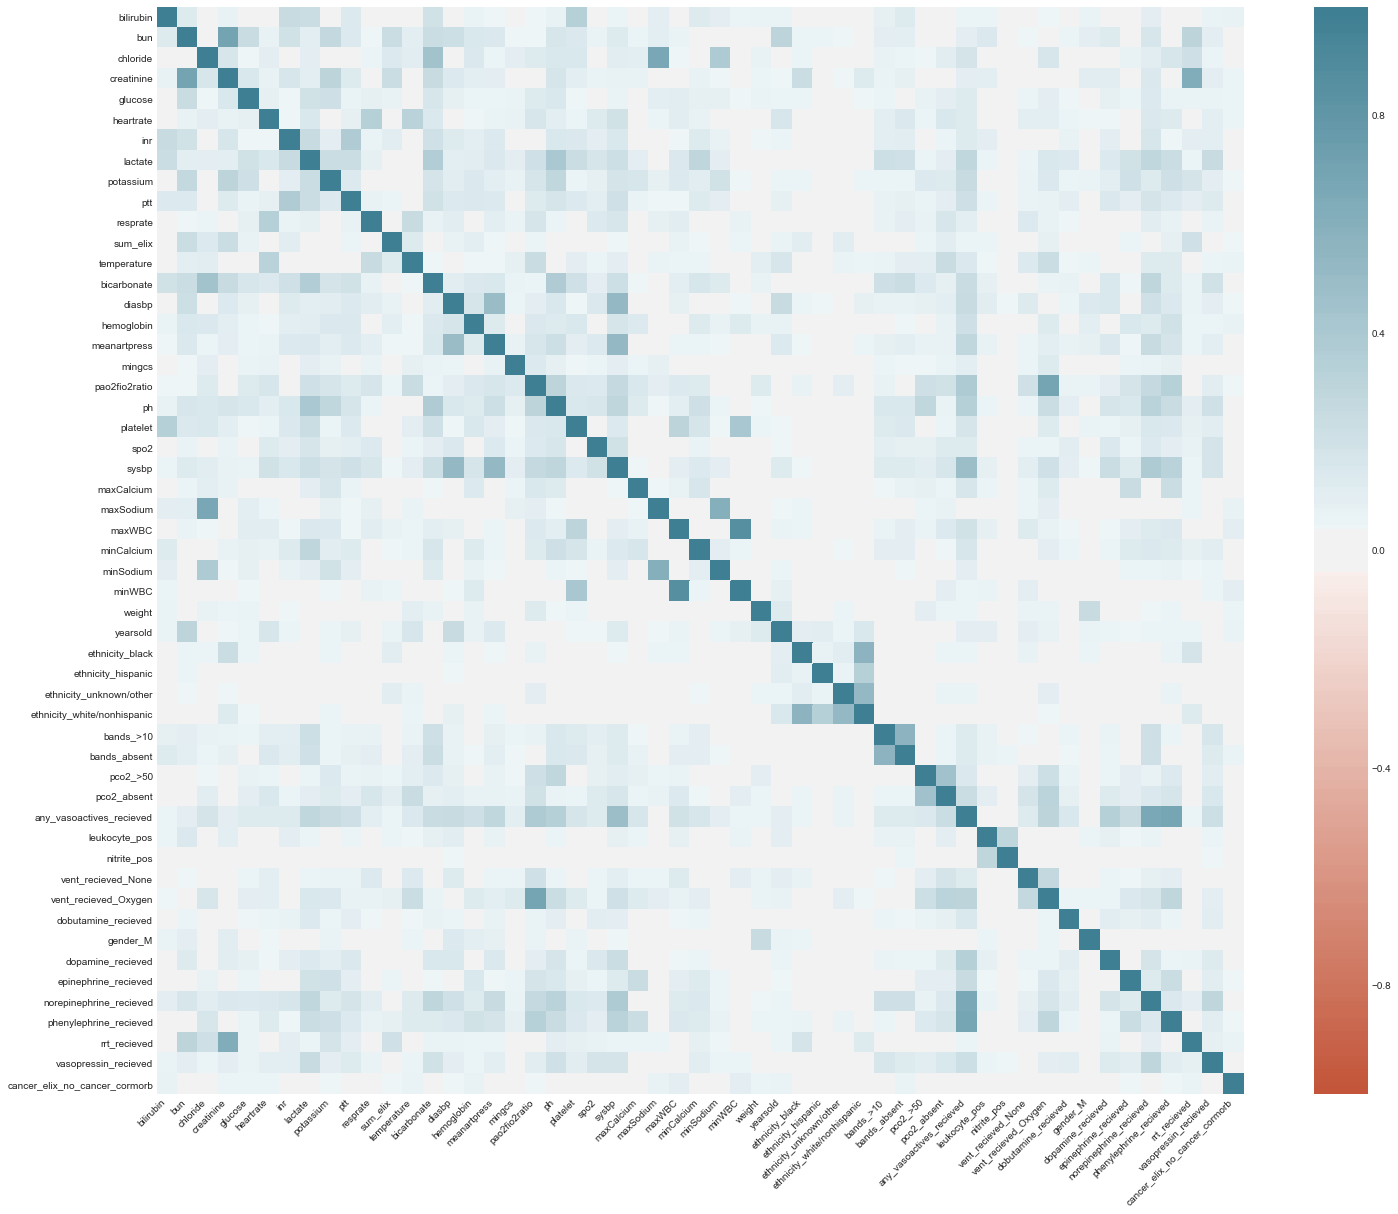

time: 2.14 s


In [40]:
corr = x_train.corr().abs()

plt.figure(figsize=(25, 20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [41]:
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
cor_df=pd.DataFrame(sol)#.sort_values(kind="quicksort") #[-10:0])
cor_df=cor_df.reset_index()
cor_df=cor_df.rename(columns={'level_0': 'corx', 'level_1': 'cory', 0:'corr'})
cor_df2=cor_df[(cor_df['corx']!=cor_df['cory']) & (cor_df['corr']>0.7)].sort_values('corr', ascending=False)
cor_df2.head()

,corx,cory,corr
0,maxWBC,minWBC,0.864341
1,bun,creatinine,0.706361


time: 18.7 ms


### DROPING one of the 2 columns with correlation >0.7  (depreciated)

In [42]:
# x_train.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')
# x_test.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')

time: 547 µs


### formatting x and y for modleing

In [107]:
x=np.array(x_train.copy())
y=y_train.copy() #copy of y_train
y=y.astype('int')
#time_interval=4

time: 7.1 ms


In [44]:
print(len(x_train),len(x_test))

7205 3100
time: 1.19 ms


In [109]:
y_train

array([0, 0, 1, ..., 0, 0, 0])

time: 2.15 ms


In [45]:
len(list(x_train))

53

time: 2.62 ms


In [46]:
def save_df(df, df_name='default', rel_path='/data/final/'):
    """
    simple function for saving result table. uses the date and supplied df name and saves to the savepath specified above.
    """
    global folder
    
    save_path= str(repository_path)+rel_path
    
    address=save_path+'{}_{}/'.format(date,folder)
    if not os.path.exists(address):
        print(address)
        os.makedirs(address)
    else:
        print(address)
        
    if address.endswith('/')==False:
        address= address+'/'
        
    if df_name == 'default':
        df_name =[x for x in globals() if globals()[x] is df][0]
        
    pd.DataFrame(df).to_csv(Path(address+'{}_{}.csv'.format(date, df_name)))


time: 29.9 ms


In [47]:
if save_boolean==True:
    save_df(x_train, 'x_train_final', rel_path='/data/final/')
    save_df(x_test, 'x_test_final', rel_path='/data/final/')
    save_df(y_train, 'y_train_final', rel_path='/data/final/')
    save_df(y_test, 'y_test_final', rel_path='/data/final/')
    save_df(z_icustay_id, 'icustay_train', rel_path='/data/final/') #just added, need to rerun all models. 12-19-19
    save_df(z_icustay_id_test, 'icustay_test', rel_path='/data/final/')


/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_48_hr_window/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_48_hr_window/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_48_hr_window/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_48_hr_window/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_48_hr_window/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_48_hr_window/
time: 969 ms


# Modelbuilding
## test entire trainset and predict trainset.
* step1) hypertune and evaluate models on 10fold cv.  
* step2) test entire train set and predict testset.
* step3) generate figures

In [48]:
from parameters import nfolds, scoring, n_iter, gridsearch
##defaults
# nfolds=10
# scoring='roc_auc'
# n_iter=20 #for gridsearch
# gridsearch=False #gridsearch=False means it does triaged hyperparameter combinations based on some algorithm. True= tests all 


time: 2.06 ms


In [49]:
def evaluate(model, x, y):
    "simple classification evaluation metrics and output used in my hypertuning functions"
    from sklearn.metrics import log_loss
    
    y_hat = model.predict(x)
    y_hat_proba = model.predict_proba(x)[:, 1] 
    errors = abs(y_hat - y)
    mape = 100 * np.mean(errors / y)
    accuracy = 100 - mape
    auc=roc_auc_score(y, y_hat_proba)
    loss= log_loss(y, y_hat_proba)
        
    print ('the AUC is: {:0.3f}'.format(auc))
    print ('the logloss is: {:0.3f}'.format(loss))
    print(confusion_matrix(y, y_hat))
    print(classification_report(y,y_hat, digits=3))
    
    if scoring=='neg_log_loss':
        return_value=loss
    elif scoring=='roc_auc':
        return_value=auc
    else:
        raise ValueError
    
    return (return_value)



time: 31.8 ms


In [50]:
def hypertuning_fxn(X, y, nfolds, model , param_grid, scoring=scoring, gridsearch=True, n_iter=20, verbose=False): 
    from sklearn.model_selection import GroupKFold

    np.random.seed(12345)
    if gridsearch==True:
        grid_search = GridSearchCV(estimator= model,
                                         param_grid=param_grid,
                                         cv=GroupKFold(nfolds),
                                         scoring=scoring,
                                         return_train_score=True,
                                         n_jobs = -1)
    else:
        grid_search = RandomizedSearchCV(estimator= model,
                                         param_distributions= param_grid,
                                         n_iter=n_iter,
                                         cv=GroupKFold(nfolds),
                                         scoring=scoring,
                                         return_train_score=True,
                                         random_state=12345,
                                         n_jobs = -1)
        
    grid_search.fit(X, y, groups=z_subject_id)    
    print(" scorer function: {}".format(scoring))
    print(" ##### CV performance: mean & sd scores #####")

    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    print('best cv score: {:0.3f}'.format(grid_search.best_score_))
    print('best cv params: ', grid_search.best_params_)

    worst_index=np.argmin(grid_search.cv_results_['mean_test_score'])
    print('worst cv score: {:0.3f}'.format(grid_search.cv_results_['mean_test_score'][worst_index]))
    print('worst cv params: ', grid_search.cv_results_['params'][worst_index])
    ##
    if verbose==True:
        for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

    print('##### training set performance #####\n')   
    print(' best hypertuned model training set performance:')
    best_random = grid_search.best_estimator_
    best_random_auc = evaluate(best_random, x, y)
    
    print(' worst hypertuned model training set performance:')
    worst_params= grid_search.cv_results_['params'][worst_index]
    worst_random=model.set_params(**worst_params)
    worst_random.fit(x,y)
    worst_random_auc = evaluate(worst_random, x, y)      
          
    print('relative scorer change of {:0.2f}%. between worst and best hyperparams on TRAINING set (may be overfit)'.format( 100 * (best_random_auc - worst_random_auc) / worst_random_auc))
    
    return(grid_search)

time: 120 ms


In [51]:
def hypertuned_cv_fxn(x, y, model_in, nfolds):
    """
    the goal of this function is to take the best hypertuned model and 
    generate average and std for F-1, precision, recall, npv, and AUC across each fold.
    Ideally i could have generated this above in my hypertuning cv function,
    but it actually took less computational time to just rerun cv on the best performing evaluator and collect all of the averaged performance metrics
    """
    
    from sklearn.model_selection import GroupKFold
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score
    from sklearn.base import clone
    
    pos_label=1
    model= clone(model_in, safe=True)
    np.random.seed(12345)
    group_kfold = GroupKFold(n_splits=nfolds)
    group_kfold.get_n_splits(x, y, z_subject_id)

    f1_y_cv=[]
    auc_y_cv=[]
    prec_y_cv=[]
    recall_y_cv=[]
    npv_y_cv=[]

    for train_index, test_index in group_kfold.split(x, y, z_subject_id):
        x_train_cv, x_test_cv = x[train_index], x[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        model.fit(x_train_cv, y_train_cv)
        
        y_proba = model.predict_proba(x_test_cv)[:,1]
        y_pred = model.predict(x_test_cv)

        fpr, tpr, thresholds = metrics.roc_curve(y_test_cv, y_proba, pos_label=pos_label)    
        #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
        youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)
        y_pred_youden = [1 if y >= youden_threshold else 0 for y in y_proba]
            
        npv_y=confusion_matrix(y_test_cv, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0)
        npv_y_cv.append(npv_y)

        prec_y= precision_score(y_true=y_test_cv, y_pred= y_pred_youden, pos_label=pos_label)
        prec_y_cv.append(prec_y)

        recall_y= recall_score(y_true=y_test_cv, y_pred= y_pred_youden, pos_label=pos_label)
        recall_y_cv.append(recall_y)

        f1_y= f1_score(y_true=y_test_cv, y_pred= y_pred_youden, pos_label=pos_label)
        f1_y_cv.append(f1_y)

        ###need to debug this.###
        auc_y=roc_auc_score(y_true=y_test_cv, y_score= y_proba)
        auc_y_cv.append(auc_y)
        
        youden_dic_cv= {'model':type(model).__name__, 
                'auc':np.mean(auc_y_cv),
                'auc_sd':np.std(auc_y_cv),
                'precision':np.mean(prec_y_cv),
                'precision_sd':np.std(prec_y_cv),
                'recall':np.mean(recall_y_cv),
                'recall_sd':np.std(recall_y_cv),
                'f1':np.mean(f1_y_cv),
                'f1_sd':np.std(f1_y_cv),
                'npv':np.mean(npv_y_cv),
                'npv_sd':np.std(npv_y_cv)}
        
    return(youden_dic_cv)

time: 145 ms


## youden index and plotting functions

In [52]:
def saveplot(plt, figure_name):
    """
    simple function for saving plots
    """
    address = str(repository_path)+'/figures/{}_{}'.format(date,folder)
    print(address)

    if not os.path.exists(address):
        os.makedirs(address)
    plt.savefig(address+"/{}.png".format(figure_name),bbox_inches='tight')

def optimal_youden_index(fpr, tpr, thresholds, tp90=True):
    """
    inputs fpr, tpr, thresholds from metrics.roc(),
    outputs the clasification threshold, roc dataframe, and the index of roc dataframe for optimal youden index
    """
    #making dataframe out of the thresholds
    roc_df= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
    roc_df.iloc[0,0] =1
    roc_df['yuden']= roc_df['tpr']-roc_df['fpr']
    
    if tp90==True:
        idx= roc_df[roc_df['tpr']>=0.9]['yuden'].idxmax() #changed this so now finds optimial yuden threshold but tp>=90%
    else:
        idx=roc_df['yuden'].idxmax() #MAX INDEX
    
    youden_threshold=roc_df.iloc[idx,0] #threshold for max youden
    return(youden_threshold, roc_df, idx)
    
def plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=save_boolean,model_name=None, folder_name=None, file_name=None):
    plt.title('ROC with optimal Youden Index')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    
    #finding the point on the line given threshold 0.5 (finding closest row in roc_df)
    og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
    plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=5, color="g")
    plt.annotate(s="P(>=0.5)",xy=(roc_df.iloc[og_idx,1]+0.02, roc_df.iloc[og_idx,2]-0.04),color='g') #textcoords
    
    plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=5, color="r") ##
    plt.annotate(s="TPR>=0.9",xy=(roc_df.iloc[idx,1]+0.02, roc_df.iloc[idx,2]-0.04),color='r' ) #textcoords
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.2)
    
    if save==True:
        saveplot(plt, figure_name="{}_roc".format(model_name))
    else: pass
    
    plt.show()
    

time: 144 ms


In [53]:
def classifier_eval(model, x=x, y=y, proba_input=False,pos_label=1, print_default=True,model_name=None, folder_name=None, save=save_boolean):
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score
    """
    classification evaluation function. able to print/save the following:
    
    print/save the following:
        ROC curve marked with threshold for optimal youden (maximizing tpr+fpr with constraint that tpr>0.9)

        using 0.5 threshold:
            confusion matrix
            classification report
            npv
            accuracy

        using optimal youden (maximizing tpr+fpr with constraint that tpr>0.9):
            confusion matrix
            classification report
            npv
            accuracy
    
    output: 
        outputs modelname, auc, precision, recall, f1, and npv to a dictionary. 
    
    notes:
    youden's J statistic:
    J= sensitivity + specificity -1
    (truepos/ truepos+falseneg) + (true neg/ trueneg + falsepos) -1. 
    NOTE: with tpr>0.9 turned on, the youden statistic is basically just the furthest point on the line away from the midline with tpr>=0.9
    NOTE2: this function arguably does too much. in the future it may be better to seperate it out into more compartmental functions like with preprocessing().
    """
    
    if proba_input==True: 
        y_proba= model
        y_pred=[1 if y >= 0.5 else 0 for y in y_proba]
    
    else:
        model_name=type(model).__name__

        y_pred = model.predict(x)
        y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
#     print("AUROC:",roc_auc)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)

    #plotting roc
    plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=save, model_name=model_name,folder_name=folder)
    plt.show(), plt.close()
    
    #printing npv, recall, precision, accuracy
    npv=confusion_matrix(y, y_pred)[0,0]/sum(np.array(y_pred)==0)
    prec= precision_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    recall= recall_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    f1= f1_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    
    if print_default==True: ###can opt to not print the 0.5 classification threshold classification report/conf matrix
        #plotting confusion matrixs
        print("\n******* Using 0.5 Classification Threshold *******\n")
        print(confusion_matrix(y, y_pred))
        print ('the Accuracy is: {:01.3f}'.format(accuracy_score(y, y_pred)))
        print ("npv: {:01.3f}".format(npv))
        print ('the classification_report:\n', classification_report(y,y_pred, digits=3))
    else:
        pass
    
    #### YOUDEN ADJUSTMENT #####

    print("\n******* Using Optimal Youden Classification Threshold *******\n")
    print("\nthe Youden optimal index is : {:01.3f}".format(youden_threshold))

    y_pred_youden = [1 if y >= youden_threshold else 0 for y in y_proba]

    npv_y=confusion_matrix(y, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0)
    prec_y= precision_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    recall_y= recall_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    f1_y= f1_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    auc_y=roc_auc_score(y_true=y, y_score= y_proba)
    
    ##plotting and saving confusion matrix
    confusion_youden=confusion_matrix(y, y_pred_youden)
    
    #plotting confusion matrixs
    print(confusion_matrix(y, y_pred_youden))
    print ('the Accuracy is: {:01.3f}'.format(accuracy_score(y, y_pred_youden)))
    print ("npv: {:01.3f}".format(npv_y))
    print ('the classification_report:\n', classification_report(y,y_pred_youden, digits=3))
    
    youden_dic= {'model':model_name, 'auc':auc_y, 'precision':prec_y, 'recall':recall_y, 'f1':f1_y, 'npv':npv_y}
    return(youden_dic)
    

time: 239 ms


## step1) hypertuning and cv
* xgboost
* randomforest
* support vector classifier
* logistic regression (l1 and l2)
* k-nearest neighbors

#### xgboost hypertune

In [54]:
###xgboost
model= XGBClassifier(n_estimators=100, min_child_weight=2, #changed: GridSearchCV ->RandomizedSearchCV
                                              gamma=0, subsample=0.8, colsample_bytree=0.8,
                                              objective='binary:logistic', n_jobs=-1, seed=27)
scale_pos_weight = [1, 5, 10] #0.1
max_depth = [1, 2, 3, 4, 5]
learning_rate=[0.01, 0.1, 0.5, 1]
param_grid = {'scale_pos_weight': scale_pos_weight, 'max_depth' : max_depth, "learning_rate":learning_rate}
xgboost_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring, n_iter=n_iter, gridsearch=gridsearch)

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.808
best cv params:  {'scale_pos_weight': 1, 'max_depth': 4, 'learning_rate': 0.1}
worst cv score: 0.718
worst cv params:  {'scale_pos_weight': 5, 'max_depth': 3, 'learning_rate': 1}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 0.901
the logloss is: 0.336
[[5392  120]
 [ 869  824]]
              precision    recall  f1-score   support

           0      0.861     0.978     0.916      5512
           1      0.873     0.487     0.625      1693

   micro avg      0.863     0.863     0.863      7205
   macro avg      0.867     0.732     0.770      7205
weighted avg      0.864     0.863     0.848      7205

 worst hypertuned model training set performance:
the AUC is: 0.959
the logloss is: 0.314
[[4626  886]
 [  67 1626]]
              precision    recall  f1-score   support

           0      0.986     0.839     0.907      5512
           1      0.6

In [55]:
y.size

7205

time: 3.92 ms


In [56]:
sum(y)

1693

time: 7.36 ms


In [57]:
xgboost_cv= hypertuned_cv_fxn(x, y, xgboost_hyper.best_estimator_, nfolds=nfolds)

time: 7.35 s


In [58]:
xgboost_cv

{'auc': 0.8077048872332366,
 'auc_sd': 0.016170778021036985,
 'f1': 0.5048161356349313,
 'f1_sd': 0.042899987771468515,
 'model': 'XGBClassifier',
 'npv': 0.9423311102908807,
 'npv_sd': 0.007402594653025198,
 'precision': 0.3513519495686923,
 'precision_sd': 0.04066192533789577,
 'recall': 0.9056022155995425,
 'recall_sd': 0.004616194069895415}

time: 4.28 ms


#### RF hypertune

In [59]:
###rf
#{'bootstrap': False, 'class_weight': None, 'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200} 
# Number of trees in random forest
n_estimators = [10,15, 25, 50, 150, 250] #[int(x) for x in np.linspace(start = 10, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = [3,10,20,'auto']
# Maximum number of levels in tree
max_depth = [5,10, 25]#[int(x) for x in np.linspace(5, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10]
# Method of selecting samples for training each tree. supposedly better with false when classes aren't perfectly ballanced
bootstrap = [True, False] #[True, False] #[False] 
#### note about bootstrap= off
###Without bootstrapping, all of the data is used to fit the model, so there is not random variation between trees with respect to the selected examples at each stage. 
###However, random forest has a second source of variation, which is the random subset of features to try at each split.
### The documentation states "The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default)," 
### which implies that bootstrap=False draws a sample of size equal to the number of training examples without replacement, i.e. the same training set is always used.
### we test this turned off because with unballanced classes turning this off can sometimes improve performance

#class_weight is either a dictionary of each class to a uniform weight for that class (e.g., {1:.9, 2:.5, 3:.01}), or is a string telling sklearn how to automatically determine this dictionary.
class_weight= [None, {0:(1/np.bincount(y))[0], 1:(1/np.bincount(y))[1]}]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight,
               'bootstrap': bootstrap}

model= RandomForestClassifier(criterion='entropy', random_state=12345)

#rf_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring,n_iter = n_iter, gridsearch=False)
rf_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring,n_iter = n_iter, gridsearch=False)

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.803
best cv params:  {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 25, 'class_weight': None, 'bootstrap': True}
worst cv score: 0.748
worst cv params:  {'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 10, 'max_depth': 25, 'class_weight': {0: 0.000181422351233672, 1: 0.0005906674542232723}, 'bootstrap': False}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 1.000
the logloss is: 0.166
[[5512    0]
 [  43 1650]]
              precision    recall  f1-score   support

           0      0.992     1.000     0.996      5512
           1      1.000     0.975     0.987      1693

   micro avg      0.994     0.994     0.994      7205
   macro avg      0.996     0.987     0.992      7205
weighted avg      0.994     0.994     0.994      7205

 worst hypertuned model 

In [106]:
y

array([0, 0, 1, ..., 0, 0, 0])

time: 2.93 ms


In [60]:
# best cv score: 0.791
# best cv params:  {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 3, 'max_depth': 25, 'class_weight': {0: 0.000181422351233672, 1: 0.0005906674542232723}, 'bootstrap': False}
    
# #changing from niter=40 and bootstrap t/f:
# best cv score: 0.788
# best cv params:  {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'class_weight': None, 'bootstrap': True}


time: 1.06 ms


In [61]:
rf_cv= hypertuned_cv_fxn(x, y, rf_hyper.best_estimator_, nfolds=nfolds)

time: 40.8 s


#### SVC hypertune

In [62]:
model= svm.SVC(probability=True)
kernel = ['linear']#, 'rbf','poly']
#gamma = [0.1, 1, 'auto'] #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default=’auto’ uses 1 / n_features
C = [0.1, 1, 10, 100] #Penalty parameter C of the error term.
degree = [1,2]
class_weight=['balanced', None]

param_grid = {'kernel': kernel,
              #'gamma': gamma,
              'C': C,
              'degree': degree,
              'class_weight':class_weight}

svc_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid,scoring=scoring, n_iter=5, gridsearch=False)
#svc_hyper=hypertuning_fxn(x, y, nfolds=4, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=10, gridsearch=False)

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.793
best cv params:  {'kernel': 'linear', 'degree': 1, 'class_weight': 'balanced', 'C': 10}
worst cv score: 0.772
worst cv params:  {'kernel': 'linear', 'degree': 2, 'class_weight': None, 'C': 0.1}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 0.802
the logloss is: 0.431
[[4181 1331]
 [ 514 1179]]
              precision    recall  f1-score   support

           0      0.891     0.759     0.819      5512
           1      0.470     0.696     0.561      1693

   micro avg      0.744     0.744     0.744      7205
   macro avg      0.680     0.727     0.690      7205
weighted avg      0.792     0.744     0.759      7205

 worst hypertuned model training set performance:
the AUC is: 0.778
the logloss is: 0.463
[[5416   96]
 [1373  320]]
              precision    recall  f1-score   support

           0      0.798     0.983     0.881      5512
      

In [63]:
svc_cv= hypertuned_cv_fxn(x, y, svc_hyper.best_estimator_, nfolds=10)

time: 4min 23s


### logistic regression hypertune

In [64]:
###logreg
model= LogisticRegression(solver='lbfgs',random_state=12345)
#model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=None)

penalty = ['l1','l2']
class_weight=['balanced',None]

param_grid = {'penalty': penalty,
              'class_weight': class_weight}

logreg_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring, n_iter=n_iter, gridsearch=True)

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.794
best cv params:  {'class_weight': 'balanced', 'penalty': 'l1'}
worst cv score: 0.790
worst cv params:  {'class_weight': None, 'penalty': 'l2'}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 0.802
the logloss is: 0.538
[[4154 1358]
 [ 509 1184]]
              precision    recall  f1-score   support

           0      0.891     0.754     0.817      5512
           1      0.466     0.699     0.559      1693

   micro avg      0.741     0.741     0.741      7205
   macro avg      0.678     0.726     0.688      7205
weighted avg      0.791     0.741     0.756      7205

 worst hypertuned model training set performance:
the AUC is: 0.798
the logloss is: 0.432
[[5262  250]
 [1150  543]]
              precision    recall  f1-score   support

           0      0.821     0.955     0.883      5512
           1      0.685     0.321     0.437      1693

  

In [65]:
logreg_cv= hypertuned_cv_fxn(x, y, logreg_hyper.best_estimator_, nfolds=10)

time: 2.57 s


### KNN hypertune

In [66]:

from sklearn.neighbors import KNeighborsClassifier
model= KNeighborsClassifier()

n_neighbors = [3,4,5, 8, 10, 25]
weights=['uniform']
p=[1,2] #1= mmanhattan, 2= euclidian


param_grid = {'n_neighbors': n_neighbors,
              'weights': weights,
              'p': p}

knn_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring, n_iter=n_iter, gridsearch=True)

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.734
best cv params:  {'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
worst cv score: 0.639
worst cv params:  {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 0.809
the logloss is: 0.438
[[5461   51]
 [1420  273]]
              precision    recall  f1-score   support

           0      0.794     0.991     0.881      5512
           1      0.843     0.161     0.271      1693

   micro avg      0.796     0.796     0.796      7205
   macro avg      0.818     0.576     0.576      7205
weighted avg      0.805     0.796     0.738      7205

 worst hypertuned model training set performance:
the AUC is: 0.916
the logloss is: 0.267
[[5325  187]
 [ 862  831]]
              precision    recall  f1-score   support

           0      0.861     0.966     0.910      5512
           1      0.816     0.491     0.613 

In [67]:
knn_cv= hypertuned_cv_fxn(x, y, knn_hyper.best_estimator_, nfolds=10)

time: 7.1 s


### Multilayer Perceptron (MLP) hypertune

In [68]:
### MLP w/ standard scalar and early stopping (improved cv performance)

from sklearn.preprocessing import StandardScaler  # doctest: +SKIP
# scaler = StandardScaler()  # doctest: +SKIP
# scaler.fit(x)  # doctest: +SKIP
# x_scalar = scaler.transform(x)  # doctest: +SKIP

from sklearn.neural_network import MLPClassifier
#hidden_layer_sizes = [(50,), (100,), (150,), (250,)] #origional used parameters #(50,50), (100,100), (150,150),(300,)

hidden_layer_sizes =[(50), (50,50), (50,50,50), (50,100,50), (100,),(150)]
solver= ['sgd', 'adam']
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],

activation= ['relu','tanh']#, 'logistic']

alpha= [0.001, 0.05] #L2 penalization degree #[0.001, 0.01]

learning_rate= ['adaptive']
learning_rate_init= [0.001, 0.01]

param_grid = {'hidden_layer_sizes': hidden_layer_sizes, 
              'solver':solver,
              'activation':activation,
              'alpha': alpha,
              'learning_rate': learning_rate,
              'learning_rate_init': learning_rate_init
             }

model= MLPClassifier(early_stopping=True, random_state=12345)

#removed teh x_scalar
mlp_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring,n_iter = 80, gridsearch=True) #gridsearch=False: testing with smaller, randomized grid
#gridsearch=False: testing with smaller, randomized grid. went from ~30 sec to 13min when ==True
# adding in solver: sgd and adam 1.5min ->8min

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.792
best cv params:  {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'solver': 'adam'}
worst cv score: 0.510
worst cv params:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'solver': 'sgd'}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 0.807
the logloss is: 0.428
[[5163  349]
 [1023  670]]
              precision    recall  f1-score   support

           0      0.835     0.937     0.883      5512
           1      0.658     0.396     0.494      1693

   micro avg      0.810     0.810     0.810      7205
   macro avg      0.746     0.666     0.688      7205
weighted avg      0.793     0.810     0.791      7205

 worst hypertuned model training set performance:
the AUC is: 0.513
the lo

In [69]:
mlp_cv= hypertuned_cv_fxn(x, y, mlp_hyper.best_estimator_, nfolds=10)


time: 7.27 s


## idea: Rashamon effect: does ensembling models improve prediction performance?
the ensemble is intresting if the ensemble predicts a different group of patients (or has different variable importance).

rashamon effect where we don't gain from ensemble: identifying same patints in different ways
rashamon effect where we do gain from ensemble: identifying DIFFERENT patients in the different ways

In [71]:
# to test this, i first need to instantiate my other models, then ensemble them together. 

time: 681 µs


In [72]:
def reset_model(model_name, hardcode=False):
    global xgboost_hyper, logreg_hyper, rf_hyper, knn_hyper, mlp_hyper, svc_hyper
    
    if model_name== 'xgboost':
        model = xgboost_hyper.best_estimator_

    elif model_name== 'logreg':
        model = logreg_hyper.best_estimator_

    elif model_name== 'rf': 
        model = rf_hyper.best_estimator_

    elif model_name== 'svc':
        model = svc_hyper.best_estimator_

    elif model_name== 'knn':
        model = knn_hyper.best_estimator_
        
    elif model_name== 'mlp':
        model = mlp_hyper.best_estimator_
        
    return(model)

time: 13 ms


# test entire trainset and predict testset.
*<del> step1) hypertune xgb via 10fold cv.
* step2) test entire trainset and predict testset.
* step3) generate figures

In [73]:
def get_auc_score(model,train_index, x=x,y=y):
    y_pred_proba = model.predict_proba(x[train_index])[:, 1] 
    roc_score=roc_auc_score(y[train_index], y_pred_proba)
    return(roc_score)

time: 2.38 ms


# Ensemble CV and testing models

## test entire trainset and predict trainset.
<del> * step1) hypertune xgb on 10fold cv.
    
<del> * step2) test entire train set and predict testset.
* step3) generate figures


In [74]:
#setting up test table
test_summary_df= pd.DataFrame({'model':[],'auc':[], 'precision':[], 'recall':[], 'f1':[], 'npv':[]})
test_summary_df

,model,auc,precision,recall,f1,npv


time: 9.34 ms


### model fitting

In [75]:
xgboost = reset_model('xgboost')
xgboost.fit(x, y)

logreg = reset_model('logreg')
logreg.fit(x, y)

rf= reset_model('rf')
rf.fit(x,y)

svc= reset_model('svc')
svc.fit(x, y)

knn= reset_model('knn')
knn.fit(x,y)

mlp= reset_model('mlp')
mlp.fit(x,y)

from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[("xgboost", xgboost), ('rf', rf), ('log_reg', logreg), ('mlp',mlp), ('svc',svc)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='soft', n_jobs=-1)
ensemble.fit(x,y)
# If ‘hard’, uses predicted class labels for majority rule voting.
# Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities,
# which is recommended for an ensemble of well-calibrated classifiers.


# from sklearn.naive_bayes import GaussianNB
# gnb =GaussianNB()
# nb_y_pred = gnb.fit(x, y)


time: 37.6 s


### wrapping up ensemble and CV

In [76]:
#running the ensemble in cv
ensemble_cv= hypertuned_cv_fxn(x, y, ensemble, nfolds=nfolds)

time: 5min 25s


In [77]:
#updating the cv table with ensemble data
cv_summary_df= pd.DataFrame([rf_cv,
                             logreg_cv,
                             xgboost_cv,
                             svc_cv,
                             knn_cv,
                             mlp_cv,
                             ensemble_cv])
cv_summary_df= cv_summary_df.set_index('model').round(decimals=3).sort_values('auc', ascending=False)

if save_boolean==True:
    save_df(cv_summary_df, df_name='default', rel_path='/tables/')

cv_summary_df

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/tables/16122019_48_hr_window/


,auc,auc_sd,f1,f1_sd,npv,npv_sd,precision,precision_sd,recall,recall_sd
model,,,,,,,,,,
XGBClassifier,0.808,0.016,0.505,0.043,0.942,0.007,0.351,0.041,0.906,0.005
VotingClassifier,0.807,0.018,0.494,0.042,0.940,0.009,0.341,0.039,0.907,0.007
RandomForestClassifier,0.803,0.021,0.491,0.054,0.940,0.009,0.339,0.051,0.910,0.009
LogisticRegression,0.794,0.020,0.486,0.037,0.938,0.010,0.333,0.035,0.907,0.009
SVC,0.793,0.018,0.484,0.039,0.940,0.009,0.331,0.036,0.911,0.007
MLPClassifier,0.792,0.018,0.491,0.030,0.939,0.008,0.337,0.028,0.906,0.003
KNeighborsClassifier,0.734,0.018,0.428,0.027,0.918,0.019,0.279,0.023,0.924,0.017


time: 58.6 ms


## global model test set evaluation

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_48_hr_window


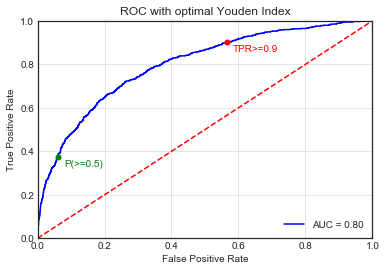


******* Using 0.5 Classification Threshold *******

[[2213  142]
 [ 468  277]]
the Accuracy is: 0.803
npv: 0.825
the classification_report:
               precision    recall  f1-score   support

           0      0.825     0.940     0.879      2355
           1      0.661     0.372     0.476       745

   micro avg      0.803     0.803     0.803      3100
   macro avg      0.743     0.656     0.677      3100
weighted avg      0.786     0.803     0.782      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.109
[[1026 1329]
 [  74  671]]
the Accuracy is: 0.547
npv: 0.933
the classification_report:
               precision    recall  f1-score   support

           0      0.933     0.436     0.594      2355
           1      0.336     0.901     0.489       745

   micro avg      0.547     0.547     0.547      3100
   macro avg      0.634     0.668     0.541      3100
weighted avg      0.789     0.547     0.569      3100

time: 482 ms


In [78]:
xgboost_eval= classifier_eval(xgboost, x=np.array(x_test), y=y_test, model_name='xgboost', folder_name=folder)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_48_hr_window


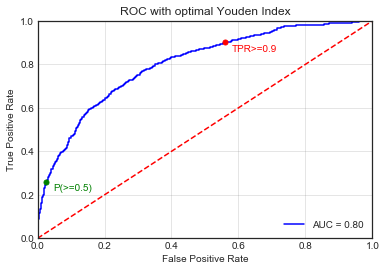


******* Using 0.5 Classification Threshold *******

[[2295   60]
 [ 553  192]]
the Accuracy is: 0.802
npv: 0.806
the classification_report:
               precision    recall  f1-score   support

           0      0.806     0.975     0.882      2355
           1      0.762     0.258     0.385       745

   micro avg      0.802     0.802     0.802      3100
   macro avg      0.784     0.616     0.634      3100
weighted avg      0.795     0.802     0.763      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.150
[[1036 1319]
 [  74  671]]
the Accuracy is: 0.551
npv: 0.933
the classification_report:
               precision    recall  f1-score   support

           0      0.933     0.440     0.598      2355
           1      0.337     0.901     0.491       745

   micro avg      0.551     0.551     0.551      3100
   macro avg      0.635     0.670     0.544      3100
weighted avg      0.790     0.551     0.572      3100

time: 658 ms


In [79]:
rf_eval= classifier_eval(rf, x=np.array(x_test), y=y_test, model_name='rf', folder_name=folder)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_48_hr_window


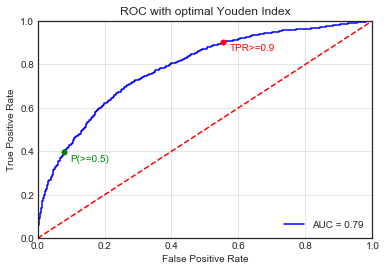


******* Using 0.5 Classification Threshold *******

[[2171  184]
 [ 451  294]]
the Accuracy is: 0.795
npv: 0.828
the classification_report:
               precision    recall  f1-score   support

           0      0.828     0.922     0.872      2355
           1      0.615     0.395     0.481       745

   micro avg      0.795     0.795     0.795      3100
   macro avg      0.722     0.658     0.677      3100
weighted avg      0.777     0.795     0.778      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.147
[[1052 1303]
 [  73  672]]
the Accuracy is: 0.556
npv: 0.935
the classification_report:
               precision    recall  f1-score   support

           0      0.935     0.447     0.605      2355
           1      0.340     0.902     0.494       745

   micro avg      0.556     0.556     0.556      3100
   macro avg      0.638     0.674     0.549      3100
weighted avg      0.792     0.556     0.578      3100

time: 698 ms


In [80]:
mlp_eval= classifier_eval(mlp, x=np.array(x_test), y=y_test, model_name='mlp', folder_name=folder)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_48_hr_window


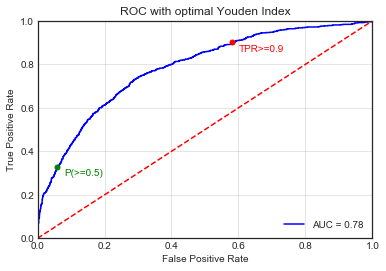


******* Using 0.5 Classification Threshold *******

[[1757  598]
 [ 237  508]]
the Accuracy is: 0.731
npv: 0.881
the classification_report:
               precision    recall  f1-score   support

           0      0.881     0.746     0.808      2355
           1      0.459     0.682     0.549       745

   micro avg      0.731     0.731     0.731      3100
   macro avg      0.670     0.714     0.678      3100
weighted avg      0.780     0.731     0.746      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.116
[[ 984 1371]
 [  74  671]]
the Accuracy is: 0.534
npv: 0.930
the classification_report:
               precision    recall  f1-score   support

           0      0.930     0.418     0.577      2355
           1      0.329     0.901     0.482       745

   micro avg      0.534     0.534     0.534      3100
   macro avg      0.629     0.659     0.529      3100
weighted avg      0.786     0.534     0.554      3100

time: 1.53 s


In [81]:
svc_eval= classifier_eval(svc, x=np.array(x_test), y=y_test, model_name='svc', folder_name=folder)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_48_hr_window


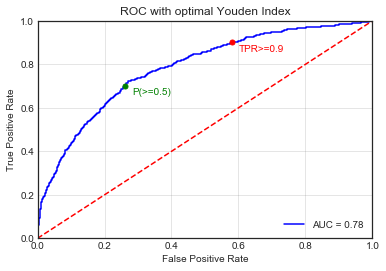


******* Using 0.5 Classification Threshold *******

[[1738  617]
 [ 222  523]]
the Accuracy is: 0.729
npv: 0.887
the classification_report:
               precision    recall  f1-score   support

           0      0.887     0.738     0.806      2355
           1      0.459     0.702     0.555       745

   micro avg      0.729     0.729     0.729      3100
   macro avg      0.673     0.720     0.680      3100
weighted avg      0.784     0.729     0.745      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.291
[[ 990 1365]
 [  74  671]]
the Accuracy is: 0.536
npv: 0.930
the classification_report:
               precision    recall  f1-score   support

           0      0.930     0.420     0.579      2355
           1      0.330     0.901     0.483       745

   micro avg      0.536     0.536     0.536      3100
   macro avg      0.630     0.661     0.531      3100
weighted avg      0.786     0.536     0.556      3100

time: 403 ms


In [82]:
# logreg_eval= classifier_eval(logreg, x=np.array(x_te
st), y=y_test)
logreg_eval= classifier_eval(logreg, x=np.array(x_test), y=y_test, model_name='logreg', folder_name=folder)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_48_hr_window


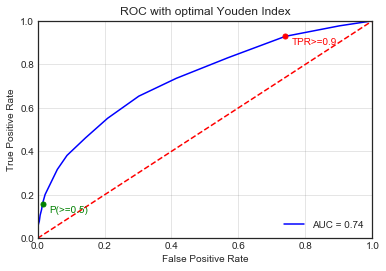


******* Using 0.5 Classification Threshold *******

[[2327   28]
 [ 647   98]]
the Accuracy is: 0.782
npv: 0.782
the classification_report:
               precision    recall  f1-score   support

           0      0.782     0.988     0.873      2355
           1      0.778     0.132     0.225       745

   micro avg      0.782     0.782     0.782      3100
   macro avg      0.780     0.560     0.549      3100
weighted avg      0.781     0.782     0.718      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.080
[[ 612 1743]
 [  53  692]]
the Accuracy is: 0.421
npv: 0.920
the classification_report:
               precision    recall  f1-score   support

           0      0.920     0.260     0.405      2355
           1      0.284     0.929     0.435       745

   micro avg      0.421     0.421     0.421      3100
   macro avg      0.602     0.594     0.420      3100
weighted avg      0.767     0.421     0.412      3100

time: 3.96 s


In [83]:
knn_eval= classifier_eval(knn, x=np.array(x_test), y=y_test, model_name='knn', folder_name=folder)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_48_hr_window


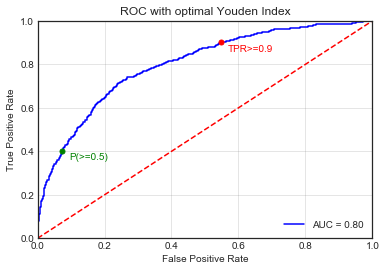


******* Using 0.5 Classification Threshold *******

[[2180  175]
 [ 448  297]]
the Accuracy is: 0.799
npv: 0.830
the classification_report:
               precision    recall  f1-score   support

           0      0.830     0.926     0.875      2355
           1      0.629     0.399     0.488       745

   micro avg      0.799     0.799     0.799      3100
   macro avg      0.729     0.662     0.682      3100
weighted avg      0.781     0.799     0.782      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.175
[[1068 1287]
 [  74  671]]
the Accuracy is: 0.561
npv: 0.935
the classification_report:
               precision    recall  f1-score   support

           0      0.935     0.454     0.611      2355
           1      0.343     0.901     0.496       745

   micro avg      0.561     0.561     0.561      3100
   macro avg      0.639     0.677     0.554      3100
weighted avg      0.793     0.561     0.583      3100

time: 1.77 s


In [89]:
ensemble_eval= classifier_eval(ensemble, 
                               x=np.array(x_test),
                               y=y_test, 
                               model_name='ensemble',
                               folder_name=folder, save=True)

looks like its the rashamon effect that doesn't benefit from ensembling.

ie there are hidden variables that can discriminate the patients.

# classification performance table

In [90]:
test_summary_df= pd.DataFrame([xgboost_eval, rf_eval, logreg_eval,  mlp_eval, svc_eval, knn_eval, ensemble_eval])
test_summary_df=test_summary_df.set_index('model').round(decimals=3).sort_values('auc', ascending=False)
if save_boolean==True:
    save_df(test_summary_df, df_name='default', rel_path='/tables/')
print(test_summary_df)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/tables/16122019_48_hr_window/
                          auc     f1    npv  precision  recall
model                                                         
RandomForestClassifier  0.801  0.491  0.933      0.337   0.901
XGBClassifier           0.799  0.489  0.933      0.336   0.901
VotingClassifier        0.799  0.496  0.935      0.343   0.901
MLPClassifier           0.786  0.494  0.935      0.340   0.902
SVC                     0.784  0.482  0.930      0.329   0.901
LogisticRegression      0.783  0.483  0.930      0.330   0.901
KNeighborsClassifier    0.736  0.435  0.920      0.284   0.929
time: 16.7 ms


# QC: checking performance on training set for xgboost and rf

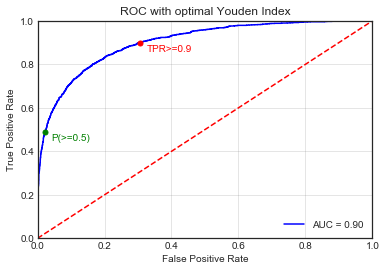


******* Using 0.5 Classification Threshold *******

[[5392  120]
 [ 869  824]]
the Accuracy is: 0.863
npv: 0.861
the classification_report:
               precision    recall  f1-score   support

           0      0.861     0.978     0.916      5512
           1      0.873     0.487     0.625      1693

   micro avg      0.863     0.863     0.863      7205
   macro avg      0.867     0.732     0.770      7205
weighted avg      0.864     0.863     0.848      7205


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.174
[[3833 1679]
 [ 169 1524]]
the Accuracy is: 0.744
npv: 0.958
the classification_report:
               precision    recall  f1-score   support

           0      0.958     0.695     0.806      5512
           1      0.476     0.900     0.623      1693

   micro avg      0.744     0.744     0.744      7205
   macro avg      0.717     0.798     0.714      7205
weighted avg      0.845     0.744     0.763      7205

time: 377 ms


In [91]:
xgboost_train= classifier_eval(xgboost, x=np.array(x_train), y=y_train, model_name='xgboost_train', folder_name=folder, save=False)

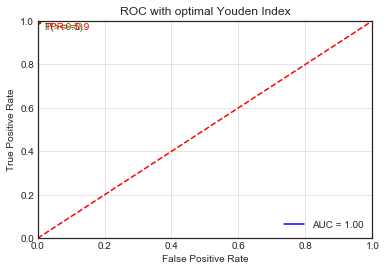


******* Using 0.5 Classification Threshold *******

[[5512    0]
 [  43 1650]]
the Accuracy is: 0.994
npv: 0.992
the classification_report:
               precision    recall  f1-score   support

           0      0.992     1.000     0.996      5512
           1      1.000     0.975     0.987      1693

   micro avg      0.994     0.994     0.994      7205
   macro avg      0.996     0.987     0.992      7205
weighted avg      0.994     0.994     0.994      7205


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.424
[[5512    0]
 [   2 1691]]
the Accuracy is: 1.000
npv: 1.000
the classification_report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000      5512
           1      1.000     0.999     0.999      1693

   micro avg      1.000     1.000     1.000      7205
   macro avg      1.000     0.999     1.000      7205
weighted avg      1.000     1.000     1.000      7205

time: 849 ms


In [92]:
rf_train= classifier_eval(rf, x=np.array(x_train), y=y_train, model_name='rf_train', folder_name=folder, save=False)

# publication figures

In [93]:
# making a model dictionary for ease of use in plotting
keys= ['rf', 'xgboost', 'logreg', 'mlp','svc', 'knn', 'ensemble']
model_list=[rf, xgboost, logreg, mlp, svc, knn, ensemble]
models_dic={}
for i in range(0,len(model_list)):
    models_dic.update({keys[i] : model_list[i]} )

time: 2.99 ms


## stacked roc curve 

In [94]:
def roc_publishing(model, x, y, proba_input=False,pos_label=1, print_default=True, model_name=None):
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score

    model_name=type(model).__name__

    y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds, tp90=True)
    
    return(fpr, tpr, roc_auc, roc_df, idx)

time: 11.8 ms


In [95]:
def stacked_roc(x_test, y_test, models_dic, first_bold=True):
    """
    plotting function to plot a stacked ROC based on models in a dictionary. 
    first_bold=True means that the first model in the dic will stand out and be a solid line, while others are dotted
    """
    
    global save_boolean
    
    plt.style.use('seaborn-white')
    plt.rcParams['figure.figsize'] = [7, 4]
    
    if first_bold==True: i=0
    else: i=1
        
#         #####
#     y_proba = model.predict_proba(x)[:,1]
        
#     fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
#     roc_auc = metrics.auc(fpr, tpr)
    
#     #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
#     youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)

#     #plotting roc
#     plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=save, model_name=model_name,folder_name=folder)    
#         ######
        
    for model_name in models_dic.keys():
        #ax4= plt.plot(fpr, tpr, label = '%s AUC = %0.3f' % (model_name, roc_auc), linestyle='dotted')
        if i==0:
            model=models_dic[model_name]
            fpr, tpr, roc_auc, roc_df, idx= roc_publishing(model, x=np.array(x_test), y=y_test, model_name=model_name)
            print(model_name, roc_auc)
            ax1= plt.plot(fpr, tpr, 'b', label = '%s AUC = %0.3f' % (model_name, roc_auc), linewidth=2)
            og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
#             plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
#             plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##
        
        else:
            model=models_dic[model_name]
            fpr, tpr, roc_auc, roc_df, idx= roc_publishing(model, x=np.array(x_test), y=y_test, model_name=model_name)
            print(model_name, roc_auc)
            ax1= plt.plot(fpr, tpr, label = '%s AUC = %0.3f' % (model_name, roc_auc), linestyle='dotted')
            og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
#             plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
#             plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##
        i+=1
        
    ###annotating the plot
    plt.legend(loc = 'lower right')   
#     plt.annotate(s="P(0.5)",xy=(0.71, 0.50),color='black', size=10) #textcoords #alt: xy=(0.78, 0.345)
#     plt.plot(0.68, 0.51, 'ro', color='black') #alt: (0.73, 0.36, 'ro', color='black')
#     plt.annotate(s="P(tuned)",xy=(0.71, 0.56),color='black', size=10) #textcoords #alt: xy=(0.78, 0.405)
#     plt.plot(0.68, 0.57, 'ro', color='r') #alt: (0.73, 0.42, 'ro', color='r')

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', size=14)
    plt.xlabel('False Positive Rate', size=14)

    if save_boolean==True:
        saveplot(plt,'stacked_roc')
    else: pass
    plt.show()

time: 111 ms


In [96]:
models_dic.keys()

dict_keys(['rf', 'xgboost', 'logreg', 'mlp', 'svc', 'knn', 'ensemble'])

time: 2.81 ms


rf 0.8010721155901338
xgboost 0.7987885264822809
logreg 0.7832211915245302
mlp 0.7856230496302312
svc 0.7835158665697715
knn 0.7359614699553998
ensemble 0.7992054603228886
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_48_hr_window


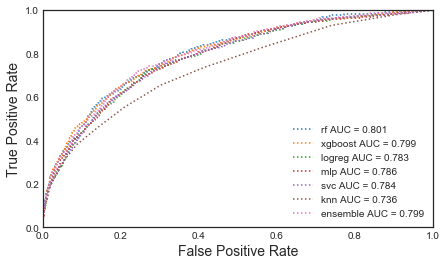

time: 3.37 s


In [97]:
stacked_roc(x_test, y_test, models_dic, first_bold=False)

# 

# variable importance
* first: find the top N (default=10) most important variables for each model
* second: make a set of all unique variables present in the combined list of all models top N variables = varimp_set
* find the variable importances for each model for varimp_set variables
* scale the variable importance for each model relative to the MOST IMPORTANT VARIABLE:
 * ie: var1= 50 (max); var2= 25; var3= 5 --> varimp: var1=100, var2=50, var3=10
* plot these as a line plot in descending order for the best performing model

In [99]:
from parameters import n_varimp

time: 940 µs


In [100]:
def find_N_varimp_set(x_train, models_dic):
    """
    function that takes in a dictionary of models and the x_train dataframe and returns the set of variables present in the combined list of each model's top N most important variables.
    1) find top N variables for each model
    2) make list of all models top N
    3) filter to only unique values in list = varimp_names
    """
    global n_varimp
    features_dic={}
    top_set_dic={}

    for model_name in models_dic.keys():
        model= models_dic[model_name]
        print(model_name)
        if model_name in ['knn','ensemble', 'mlp']:
            pass
        elif model_name in ['logreg','svc']:
            feature_importance = abs(model.coef_[0])
            sorted_idx = np.argsort(feature_importance)[-n_varimp:]#[0]
            features =list(np.array(x_train.columns)[sorted_idx][-n_varimp:])
            features_dic.update( {model_name :features } )
        else:
            feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
            features=feat_importances.nlargest(n_varimp).sort_values()
            features=list(features.reset_index()['index'])
            features_dic.update( {model_name :features } )
    #######
    set_features=[]

    for features in features_dic.values():
        set_features=set_features+features
    set_features=set(set_features)
    varimp_names=list(set_features)

    return(varimp_names)

time: 38.4 ms


In [101]:
def topN_rel_imp(models_dic, varimp_names):
    """
    input:dictionary of models and the top N set of important variables among models
    output: relative variable importance for each model of all set(varimp_names) variables.
    note: relative variable importance determined by dividing each variable importance by the value of the most important variable. this makes all values a comparison to the most important varaible:
    ie 50 rel variable importance = half as important as the most important variable
    """
    
    # finding the index of the set(varimp_names) in the dataframe.  
    #getting index of the set(top10) variables in x_train
    xtrain_column_index_list=[]
    for element in varimp_names:
        variable_index=list(x_train).index(element)
        xtrain_column_index_list.append(variable_index)
    
    top_set_dic={} #instantiating dictionary
    for model_name in models_dic.keys(): ##now that we have set of top N variables for each model. we can make relative importance for all unique variables in the set
        model= models_dic[model_name]
        if model_name in ['knn','ensemble', 'mlp']:
            pass
        
        elif model_name in ['logreg','svc']: 
            imp= abs(model.coef_[0])[xtrain_column_index_list]
            rel_imp=100.0 * (imp / imp.max())
            features =list(np.array(x_train.columns)[xtrain_column_index_list])#[-n_varimp:])
            top_set= pd.Series(rel_imp,features).sort_values()
            top_set_dic.update( {model_name :top_set } )

        else:
            imp=pd.Series(models_dic[model_name].feature_importances_, index=x_train.columns)[xtrain_column_index_list]
            imp=imp.sort_values()
            rel_imp=100.0 * (imp / imp.max())
            features =list(np.array(x_train.columns)[xtrain_column_index_list])
            top_set= rel_imp
            top_set_dic.update( {model_name :top_set } )

    return(top_set_dic)

time: 32.8 ms


In [102]:
def roc_name_adjust(varimp_names):
    """
    cleans up the column names for the variable importance plot for publishing
    """
    adjusted_names=[]
    mapper={'vent_recieved_2.0': 'mechanical ventilation recieved',
            'vent_recieved_1.0': 'oxygen ventilation recieved',
            'vent_recieved_1.0': 'no ventilation recieved',
            'pao2fio2ratio':'PaO2:FiO2',
#             'pao2fio2ratio_(475, 3000]': 'PaO2:FiO2 (475-3000)',
#             'pao2fio2ratio_(200, 333]': 'PaO2:FiO2 (200-333)',
#             'pao2fio2ratio_(333, 475]': 'PaO2:FiO2 (333-475)',
            'ipco2_>50': 'pCO2 (>50)',
            'ibands_>10': 'bands (>10)',
            'ibands_absent': 'bands (missing)'}
    
    for element in varimp_names:
        if element in mapper.keys():
            element= mapper[element]
            adjusted_names.append(element)
        elif "_1.0" in element:
            element= element.strip("_1.0") + ' (Y/N)'
            adjusted_names.append(element)
        else:
            adjusted_names.append(element)
        
    return(adjusted_names)

time: 12.4 ms


In [103]:
def plot_topN_rel_imp(top_set_dic, varimp_names, xvar_rotation=80):
    """
    plot the variable importance plots as a lineplot
    rotation: the amount of xvar rotation
    """
    global save_boolean
    
    df_base=pd.DataFrame(index=varimp_names)  

    for model_name in top_set_dic.keys():
        df_base[model_name]= top_set_dic[model_name]

    adjusted_names=roc_name_adjust(varimp_names)
    df_base.index=adjusted_names
    df_base.sort_values('rf', ascending=False)

    plt.style.use('seaborn-ticks')
    plt.rcParams['figure.figsize'] = [10,10]#[7, 7]
    plt.plot(df_base.sort_values('rf', ascending=True))
    #plt.set_xticklabels(adjusted_names,rotation=30)
    plt.xticks(rotation=xvar_rotation)#, ha='right')
    plt.ylabel("Relative Variable Importance")
    plt.legend(list(df_base))
    
    if save_boolean==True:
        saveplot(plt,'variable_importance')

    return(df_base)

time: 21.6 ms


rf
xgboost
logreg
mlp
svc
knn
ensemble
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_48_hr_window


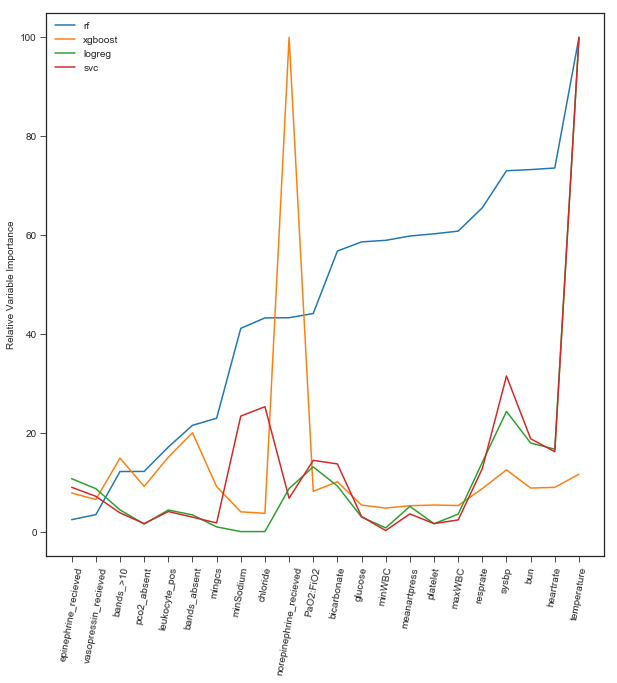

time: 629 ms


In [104]:
#find set(topN) variables
varimp_names= find_N_varimp_set(x_train, models_dic)

#find rel importance of set(topN) variables for each model
top_set_dic= topN_rel_imp(models_dic, varimp_names)

#plot the variable importance plot
topN_rel_imp_df= plot_topN_rel_imp(top_set_dic, varimp_names, xvar_rotation=80)

In [105]:
all_features=[
    'bilirubin','bun','chloride',
     'creatinine','glucose','heartrate',
     'inr','lactate','potassium',
     'ptt','resprate','sum_elix',
     'temperature','bicarbonate','diasbp',
     'hemoglobin','meanartpress','mingcs',
     'pao2fio2ratio','ph','platelet',
     'spo2','sysbp','maxCalcium',
     'maxSodium','maxWBC','minCalcium',
     'minSodium','minWBC','weight',
     'yearsold','ethnicity_black','ethnicity_hispanic',
     'ethnicity_unknown/other','ethnicity_white/nonhispanic','bands_>10',
     'bands_absent','pco2_>50','pco2_absent',
     'any_vasoactives_recieved','leukocyte_pos','nitrite_pos',
     'vent_recieved_None','vent_recieved_Oxygen','dobutamine_recieved',
     'gender_M','gender_NA','dopamine_recieved',
     'epinephrine_recieved','norepinephrine_recieved','phenylephrine_recieved',
     'rrt_recieved','vasopressin_recieved','cancer_elix_no_cancer_cormorb'
]

time: 6.12 ms


# Model Saving

In [ ]:
def model_save(model, model_name):
    import pickle
    modelpath=str(repository_path)+'/models/{}_{}'.format(date,folder)

    if not os.path.exists(modelpath):
        print(modelpath)
        os.makedirs(modelpath)

    filename = str(modelpath)+'/finalized_{}.sav'.format(model_name)
    pickle.dump(model, open(filename, 'wb'))

In [ ]:
model_save(xgboost,'xgboost')
model_save(rf,'rf')
model_save(logreg,'logreg')
model_save(svc,'svc')
model_save(knn,'knn')
model_save(mlp,'mlp')
model_save(ensemble,'ensemble')

In [ ]:
folder

In [ ]:
date

cool model debugging code, useful to make validation curves across hyperparameters:

In [ ]:
# def val_curve_plot(train_scoreNum, test_scoreNum, param_range, param_name, rename_x_tick=False, param_range_name=['0','1']):
#     """quick function to plot a validation curve across different hyperparameters"""
#     plt.rcParams['figure.figsize'] = [7, 4]
    
#     train_scores_mean = np.mean(train_scoreNum, axis=1)
#     train_scores_std = np.std(train_scoreNum, axis=1)
#     test_scores_mean = np.mean(test_scoreNum, axis=1)
#     test_scores_std = np.std(test_scoreNum, axis=1)

#     plt.title("Validation Curve with RF and parameter:{}".format(param_name))
#     plt.xlabel(r"$\gamma$")
#     plt.ylabel("Score")
#     plt.ylim(0.6, 1.1)
#     try:
#         plt.xlim(0, max(param_range))
#     except TypeError:
#         pass
#     lw = 2

#     if rename_x_tick==False:
#         param_range_name=param_range
#     plt.errorbar(param_range_name,train_scores_mean, yerr=train_scores_std, alpha=0.6, color='darkorange', lw=lw, label='train')
#     plt.errorbar(param_range_name,test_scores_mean, yerr=test_scores_std, alpha=0.6, color='blue', lw=lw, label='test')
#     plt.legend(loc='best')
#     plt.show()

In [ ]:
# from sklearn.model_selection import validation_curve

# param_range=[2, 10, 15, 25, 35, 50, 200]#[100, 300, 500, 750, 800, 1200]

# train_scoreNum, test_scoreNum = validation_curve(
#                                 RandomForestClassifier(),
#                                 X = x, y = y, 
#                                 param_name = 'n_estimators', 
#                                 param_range = param_range, cv = 5)

# val_curve_plot(train_scoreNum, test_scoreNum, param_range, param_name='n_estimators')

In [ ]:
#list(x_train2.loc[:,[x for x in list(x_train2) if x not in categorical]])

# exploring LIME visualization package (depreciated at current point)

In [ ]:
# x_train2=x_train.copy()

In [ ]:
# # trying to get LIME package working
# import lime
# import lime.lime_tabular

In [ ]:
# explainer = lime.lime_tabular.LimeTabularExplainer(np.array(x_train), feature_names=list(x_train), class_names=[0,1], discretize_continuous=True)

# explainer = lime.lime_tabular.LimeTabularExplainer(train ,feature_names = feature_names,class_names=class_names,
#                                                    categorical_features=categorical_features, 
#                                                    categorical_names=categorical_names, kernel_width=3

In [ ]:
# i = np.random.randint(0, x_test.shape[0])
# exp = explainer.explain_instance(np.array(x_test)[i], rf.predict_proba, num_features=len(list(x_train)), top_labels=1)
# exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
# y_test[i]

In [ ]:
# np.array(x_test)[i]

In [ ]:
# x_test.iloc[i,:5]

In [ ]:
# exp = explainer.explain_instance(np.array(x_test)[i], xgboost.predict_proba, num_features=len(list(x_train)), top_labels=1)
# exp.show_in_notebook(show_table=True, show_all=False)

Now, there is a lot going on here. First, note that the row we are explained is displayed on the right side, in table format. Since we had the show_all parameter set to false, only the features used in the explanation are displayed.

The value column displays the original value for each feature.

Note that LIME has discretized the features in the explanation. This is because we let discretize_continuous=True in the constructor (this is the default). Discretized features make for more intuitive explanations.

In [ ]:
folder